In [25]:
#
#     MIT No Attribution
#
#     Copyright (C) 2010-2023 Joel Andersson, Joris Gillis, Moritz Diehl, KU Leuven.
#
#     Permission is hereby granted, free of charge, to any person obtaining a copy of this
#     software and associated documentation files (the "Software"), to deal in the Software
#     without restriction, including without limitation the rights to use, copy, modify,
#     merge, publish, distribute, sublicense, and/or sell copies of the Software, and to
#     permit persons to whom the Software is furnished to do so.
#
#     THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
#     INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A
#     PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT
#     HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION
#     OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE
#     SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
#
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt


In [26]:
# Degree of interpolating polynomial
d = 3

# Get collocation points
tau_root = np.append(0, ca.collocation_points(d, 'legendre'))
tau_root

array([0.        , 0.11270167, 0.5       , 0.88729833])

In [27]:
# Coefficients of the collocation equation
C = np.zeros((d+1,d+1))

# Coefficients of the continuity equation
D = np.zeros(d+1)

# Coefficients of the quadrature function
B = np.zeros(d+1)

In [28]:
# Construct polynomial basis
for j in range(d+1):
    # Construct Lagrange polynomials to get the polynomial basis at the collocation point
    p = np.poly1d([1])
    for r in range(d+1):
        if r != j:
            p *= np.poly1d([1, -tau_root[r]]) / (tau_root[j]-tau_root[r])

    # Evaluate the polynomial at the final time to get the coefficients of the continuity equation
    D[j] = p(1.0)

    # Evaluate the time derivative of the polynomial at all collocation points to get the coefficients of the continuity equation
    pder = np.polyder(p)
    for r in range(d+1):
        C[j,r] = pder(tau_root[r])

    # Evaluate the integral of the polynomial to get the coefficients of the quadrature function
    pint = np.polyint(p)
    B[j] = pint(1.0)

In [29]:
# Time horizon
T = 10.

# Declare model variables
x1 = ca.SX.sym('x1')
x2 = ca.SX.sym('x2')
x = ca.vertcat(x1, x2)
u = ca.SX.sym('u')

In [30]:
# Model equations
xdot = ca.vertcat((1-x2**2)*x1 - x2 + u, x1)

# Objective term
L = x1**2 + x2**2 + u**2

# Continuous time dynamics
f = ca.Function('f', [x, u], [xdot, L], ['x', 'u'], ['xdot', 'L'])
print("f:", f)

f: f:(x[2],u)->(xdot[2],L) SXFunction


In [31]:
# Control discretization
N = 20 # number of control intervals
h = T/N

# Start with an empty NLP
w=[]
w0 = []
lbw = []
ubw = []
J = 0
g=[]
lbg = []
ubg = []

# For plotting x and u given w
x_plot = []
u_plot = []


In [32]:
# "Lift" initial conditions
Xk = ca.MX.sym('X0', 2)
w.append(Xk)
lbw.append([0, 1])
ubw.append([0, 1])
w0.append([0, 1])
x_plot.append(Xk)

In [33]:
# Formulate the NLP
for k in range(N):
    # New NLP variable for the control
    Uk = ca.MX.sym('U_' + str(k))
    w.append(Uk)
    lbw.append([-1])
    ubw.append([1])
    w0.append([0])
    u_plot.append(Uk)

    # State at collocation points
    Xc = []
    for j in range(d):
        Xkj = ca.MX.sym('X_'+str(k)+'_'+str(j), 2)
        Xc.append(Xkj)
        w.append(Xkj)
        lbw.append([-0.25, -np.inf])
        ubw.append([np.inf,  np.inf])
        w0.append([0, 0])

    # Loop over collocation points
    Xk_end = D[0]*Xk
    for j in range(1,d+1):
       # Expression for the state derivative at the collocation point
       xp = C[0,j]*Xk
       for r in range(d): xp = xp + C[r+1,j]*Xc[r]

       # Append collocation equations
       fj, qj = f(Xc[j-1],Uk)
       g.append(h*fj - xp)
       lbg.append([0, 0])
       ubg.append([0, 0])

       # Add contribution to the end state
       Xk_end = Xk_end + D[j]*Xc[j-1];

       # Add contribution to quadrature function
       J = J + B[j]*qj*h

    # New NLP variable for state at end of interval
    Xk = ca.MX.sym('X_' + str(k+1), 2)
    w.append(Xk)
    lbw.append([-0.25, -np.inf])
    ubw.append([np.inf,  np.inf])
    w0.append([0, 0])
    x_plot.append(Xk)

    # Add equality constraint
    g.append(Xk_end-Xk)
    lbg.append([0, 0])
    ubg.append([0, 0])

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      852
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      180
                     variables with only lower bounds:       80
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:      160
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.00e+00 8.95e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

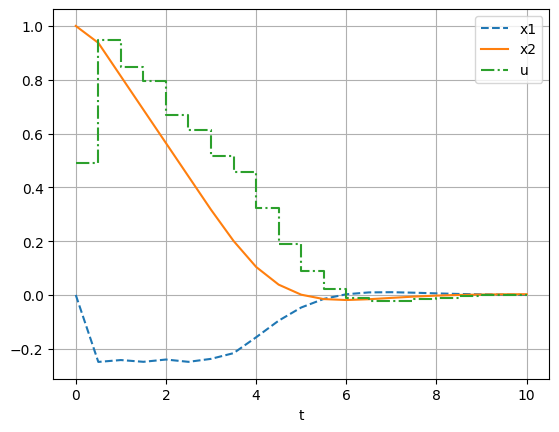

In [34]:
# Concatenate vectors
w = ca.vertcat(*w)
g = ca.vertcat(*g)
x_plot = ca.horzcat(*x_plot)
u_plot = ca.horzcat(*u_plot)
w0 = np.concatenate(w0)
lbw = np.concatenate(lbw)
ubw = np.concatenate(ubw)
lbg = np.concatenate(lbg)
ubg = np.concatenate(ubg)

# Create an NLP solver
prob = {'f': J, 'x': w, 'g': g}
solver = ca.nlpsol('solver', 'ipopt', prob)

# Function to get x and u trajectories from w
trajectories = ca.Function('trajectories', [w], [x_plot, u_plot], ['w'], ['x', 'u'])

# Solve the NLP
sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
x_opt, u_opt = trajectories(sol['x'])
x_opt = x_opt.full() # to numpy array
u_opt = u_opt.full() # to numpy array

# Plot the result
tgrid = np.linspace(0, T, N+1)
plt.figure(1)
plt.clf()
plt.plot(tgrid, x_opt[0], '--')
plt.plot(tgrid, x_opt[1], '-')
plt.step(tgrid, np.append(np.nan, u_opt[0]), '-.')
plt.xlabel('t')
plt.legend(['x1','x2','u'])
plt.grid()
plt.show()